# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Traffic Sign Recognition Classifier

In this project I am training a deep learning model to classify traffic signs using LeNet5 architecture. The dataset used for this project is German Traffic Sign dataset. 

---
### Load Dataset

In [1]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

### Dataset Summary

Here is the collage of sample images in the dataset and summary

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


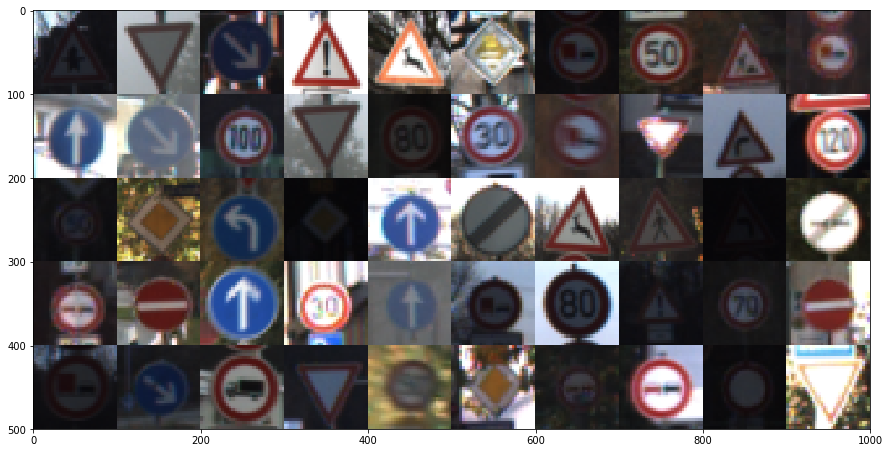

In [2]:
from PIL import Image
import random
import matplotlib.pyplot as plt

# Number of training examples
n_train = np.shape(X_train)[0]

# Number of validation examples
n_validation = np.shape(X_valid)[0]

# Number of testing examples.
n_test = np.shape(X_test)[0]

# Shape of an traffic sign image
image_shape = np.shape(X_train[0])

# Number of unique traffic signs
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# Display image collage

# Collage image size
coll_width = 1000
coll_height = 500
collage = Image.new('RGB', (coll_width, coll_height))

# Number of images along rows and columns in collage
rows = 5
cols = 10
thumb_width = int(coll_width/cols)
thumb_height = int(coll_height/rows)

coll_y = 0

for i in range(rows):
    coll_x = 0
    for j in range(cols):
        # Generate random index
        idx = random.randint(0, n_train)
        # Convert ndarray image to PIL Image
        img = Image.fromarray(X_train[idx])
        # Generate image thumbnail(resize)
        img = img.resize((thumb_width, thumb_height))
        # Paste the thumbnail to in the collage
        collage.paste(img, (coll_x,coll_y))
        # Update thumbnail position
        coll_x += thumb_width
        
    coll_y += thumb_height

# Display collage
%matplotlib inline
fig = plt.figure(figsize = (15,15))
plt.imshow(collage)

### Training image and corresponding label

Traffic sign:  No entry


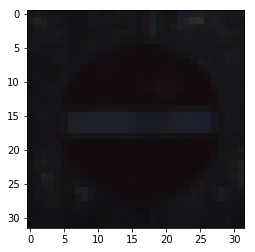

In [3]:
import csv

# Read csv file to get traffic sign names
sign_names = []
with open('signnames.csv') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        sign_names.append(row[1])

# Get random training image and print corresponding label
%matplotlib inline
index = random.randint(0,n_train)
plt.imshow(X_train[index])
#print("Traffic sign index = ", y_train[index])
print("Traffic sign: ", sign_names[y_train[index]+1])

### Number of training images of each traffic sign type

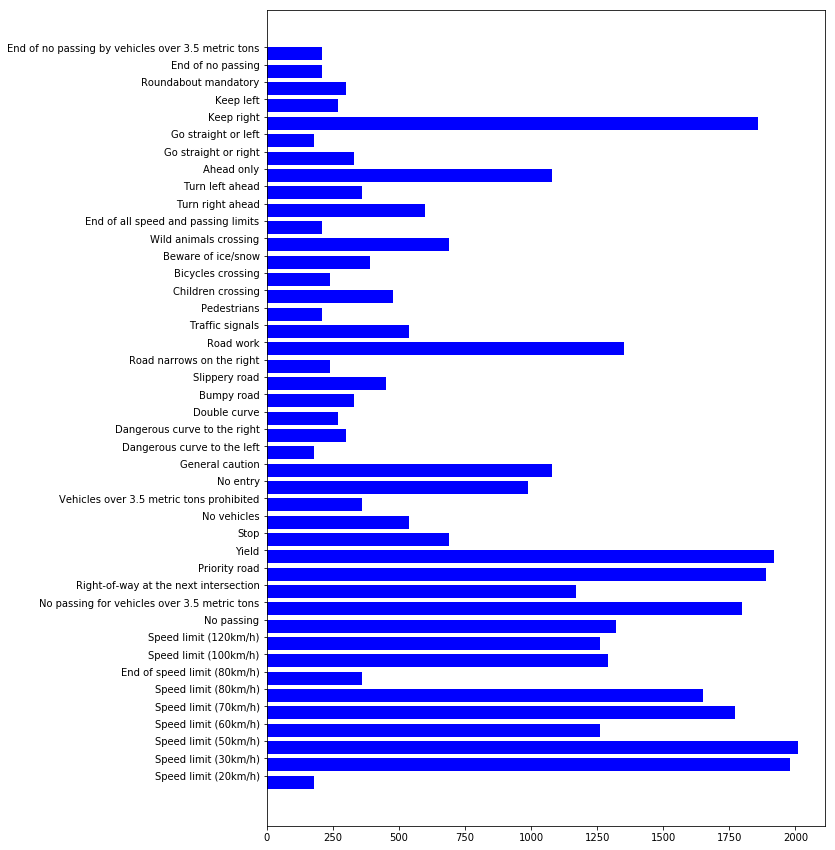

In [4]:
sign_dict = dict()

for i in range(n_train):
    if(y_train[i] in sign_dict):
        sign_dict[y_train[i]] += 1
    else:
        sign_dict[y_train[i]] = 1
        
plt.rcParams['figure.figsize'] = (10,15)
fig, ax = plt.subplots()
idx = np.arange(n_classes)
width = 0.75
names = [sign_names[id+1] for id in sign_dict.keys()]
ax.barh(idx, sign_dict.values(), width, align='center', color='blue')
ax.set_yticks(idx+width/2)
bar_labels = ax.set_yticklabels(names, minor=False)

We can see that the training images for some of the traffic signs in quite less compared to others, so we will augment the images for these traffic signs and build a bigger dataset.

### Augment Dataset with rotated images

In [5]:
# Augment dataset with rotated images
import time
from tqdm import *
from scipy.ndimage.interpolation import rotate
from numpy import newaxis

# Calculate number of types each traffic sign to augment
size = 1500
sign_count_dict = dict()
for d in list(sign_dict.keys()):
    temp = size/sign_dict[d]
    if(temp > 0):
        sign_count_dict[d] = int(temp)
    else:
        sign_count_dict[d] = 0
    
X_train_aug = X_train
y_train_aug = y_train

it = len(y_train)


# For traffic sign images whose count is less than size, augment rotated images
for i in tqdm(range(it)):
    if(sign_count_dict[y_train_aug[i]] > 0):
        count = 0
        angle = 10
        while(count < sign_count_dict[y_train_aug[i]]):
            # Rotate image to left by angle
            rot_imgs = rotate(X_train_aug[i], angle, reshape=False)[newaxis,:,:,:]
            # Rotate image to right by angle
            rot_imgs = np.concatenate((rot_imgs, rotate(X_train_aug[i],-angle,reshape=False)[newaxis,:,:,:]))
            
            # Add the rotated image to the dataset
            X_train_aug = np.concatenate((X_train_aug, rot_imgs))
            y_train_aug = np.append(y_train_aug, y_train_aug[i])
            y_train_aug = np.append(y_train_aug, y_train_aug[i])
            angle += 10
            count += 2

print("Finished augmenting dataset with rotated images")
print("Augmented training set size = ", np.shape(X_train_aug)[0])


100%|██████████| 34799/34799 [27:15<00:00, 21.27it/s]  

Finished augmenting dataset with rotated images
Augmented training set size =  95517


### Augment the dataset with noisy images

In [6]:
# Calculate number of types each traffic sign to augment
#it = len(y_train_aug)
X_train_aug_noisy = X_train_aug[0][newaxis,:,:,:]
y_train_aug_noisy = y_train_aug[0]

# For traffic sign images whose count is less than size, augment noisy images
for i in tqdm(range(it)):
        # Calculate noisy image
        noisy_img = X_train_aug[i] + X_train_aug[i].std() * np.random.random(X_train_aug[i].shape)
        noisy_img = noisy_img[newaxis,:,:,:]
            
        X_train_aug_noisy = np.concatenate((X_train_aug_noisy, noisy_img))
        y_train_aug_noisy = np.append(y_train_aug_noisy, y_train_aug[i])
        
X_train_aug = np.concatenate((X_train_aug, X_train_aug_noisy))
y_train_aug = np.concatenate((y_train_aug, y_train_aug_noisy))

print("Finished augmenting dataset with noisy images")
print("Augmented training set size = ", np.shape(X_train_aug)[0])
n_train = np.shape(X_train_aug)[0]

100%|██████████| 34799/34799 [59:00<00:00,  5.07it/s]  


Finished augmenting dataset with noisy images
Augmented training set size =  130317


### Sample image from augmented dataset

Traffic sign:  Bumpy road


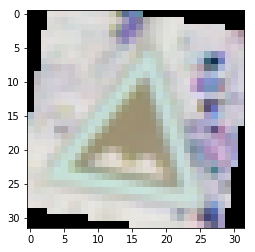

In [12]:
plt.rcParams['figure.figsize'] = (3,3)
%matplotlib inline
index = 45000
plt.imshow(X_train_aug[index])
print("Traffic sign: ", sign_names[y_train_aug[index]+1])

### Number of training images of each type traffic sign type in augmented dataset

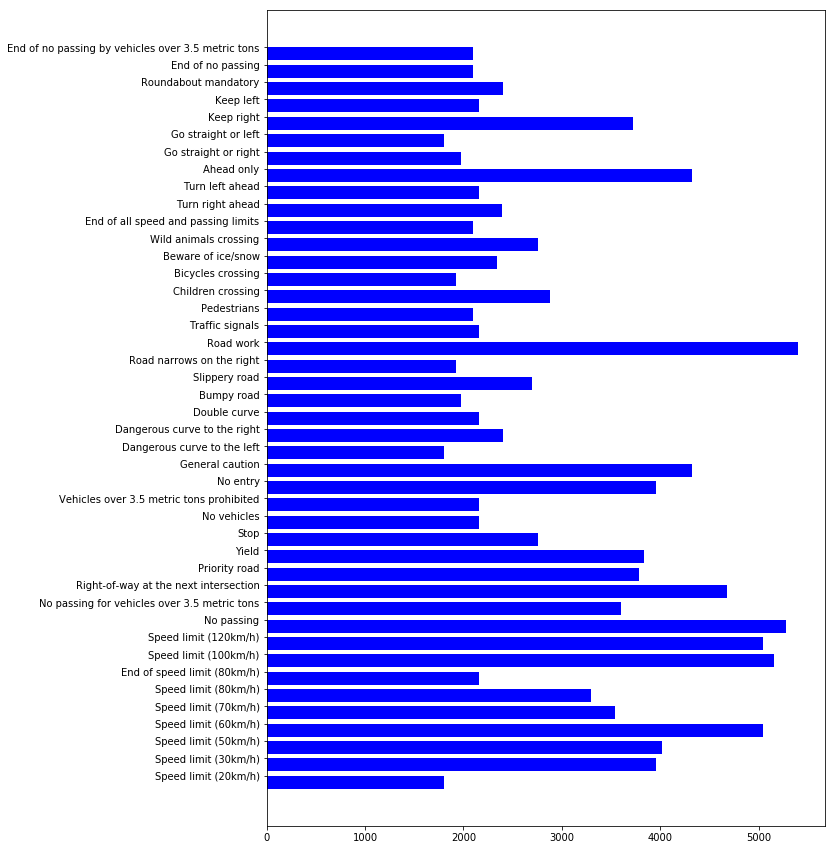

In [13]:
sign_aug_dict = dict()

for i in range(len(y_train_aug)):
    if(y_train_aug[i] in sign_aug_dict):
        sign_aug_dict[y_train_aug[i]] += 1
    else:
        sign_aug_dict[y_train_aug[i]] = 1
        
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,15)
fig, ax = plt.subplots()
idx = np.arange(n_classes)
width = 0.75
names = [sign_names[id+1] for id in sign_aug_dict.keys()]
ax.barh(idx, sign_aug_dict.values(), width, align='center', color='blue')
ax.set_yticks(idx+width/2)
bar_labels = ax.set_yticklabels(names, minor=False)

### Normalize Dataset

In [14]:
# Normalize dataset
X_train_aug = X_train_aug.astype(np.float32)
X_train_aug = (X_train_aug - 128)/128

X_valid = X_valid.astype(np.float32)
X_valid = (X_valid - 128)/128

X_test = X_test.astype(np.float32)
X_test = (X_test - 128)/128

print("Normalized Dataset")

Normalized Dataset


### LeNet5 Model Architecture

In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle

import tensorflow as tf

# LeNet5 architecture
def lenet(x):
    # Layer1: Convolution, input=32x32x3, output=28x28x6
    w_l1 = tf.Variable(tf.truncated_normal(shape=(5,5,3,6), mean=0.0, stddev=0.1))
    b_l1 = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, w_l1, strides=[1,1,1,1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, b_l1)
    conv1 = tf.nn.relu(conv1)
    
    # Layer 2: Max Pooling, input=28x28x6, output=14x14x6
    maxpool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer 3: Convolution, input=14x14x6, output=10x10x16
    w_l2 = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=0.0, stddev=0.1))
    b_l2 = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(maxpool1, w_l2, strides=[1,1,1,1,], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, b_l2)
    conv2 = tf.nn.relu(conv2)
    
    # Layer 4: Max Pooling, input=10x10x16, output=5x5x16
    maxpool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Flatten output of layer 4
    x_flat = tf.contrib.layers.flatten(maxpool2)
    
    # Layer 5: Fully-connected layer, input=400, output=120
    w_fc1 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=0.0, stddev=0.1))
    b_fc1 = tf.Variable(tf.zeros(120))
    fc1 = tf.add(tf.matmul(x_flat, w_fc1), b_fc1)
    fc1 = tf.nn.relu(fc1)
    
    # Layer 6: Fully-connected layer, input=120, output=84
    w_fc2 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=0.0, stddev=0.1))
    b_fc2 = tf.Variable(tf.zeros(84))
    fc2 = tf.add(tf.matmul(fc1, w_fc2), b_fc2)
    fc2 = tf.nn.relu(fc2)
    
    # Layer 7: Fully-connected layer, input=84, output=n_classes
    w_fc3 = tf.Variable(tf.truncated_normal(shape=(84,n_classes), mean=0.0, stddev=0.1))
    b_fc3 = tf.Variable(tf.zeros(n_classes))
    fc3 = tf.add(tf.matmul(fc2, w_fc3), b_fc3)
    
    return fc3

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Training operation
EPOCHS = 30
BATCH_SIZE = 128
learn_rate = 0.001
from sklearn.utils import shuffle
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)

logits = lenet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate)
training_operation = optimizer.minimize(loss)

# Validation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# Function to perform evaluation
def evaluate(X_data, y_data):
    num_examples = len(y_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        X_batch, y_batch = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: X_batch, y: y_batch})
        total_accuracy += accuracy * len(y_batch)
    return(total_accuracy / num_examples)

# Train Model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train_aug)
    print("Training ...")
    
    for i in range(EPOCHS):
        X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
        for offset in range(0, num_examples, BATCH_SIZE):
            X_batch, y_batch = X_train_aug[offset:offset+BATCH_SIZE],y_train_aug[offset:offset+BATCH_SIZE]
            sess.run(training_operation, feed_dict={x:X_batch, y:y_batch})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH = ", i)
        print("Validation Accuracy = ", validation_accuracy)
        
    # Test accuracy on test set
    test_accuracy = evaluate(X_test, y_test)
    print("\nTest set accuracy = ", test_accuracy)
    
    # Save Trained model
    saver.save(sess, "./LeNet/")
    print("Saved trained model")

Training ...
EPOCH =  0
Validation Accuracy =  0.863492063762
EPOCH =  1
Validation Accuracy =  0.895464852635
EPOCH =  2
Validation Accuracy =  0.900226757126
EPOCH =  3
Validation Accuracy =  0.899092970603
EPOCH =  4
Validation Accuracy =  0.924036281449
EPOCH =  5
Validation Accuracy =  0.912018140346
EPOCH =  6
Validation Accuracy =  0.919727891183
EPOCH =  7
Validation Accuracy =  0.913832199817
EPOCH =  8
Validation Accuracy =  0.914965986422
EPOCH =  9
Validation Accuracy =  0.92358276671
EPOCH =  10
Validation Accuracy =  0.924036281449
EPOCH =  11
Validation Accuracy =  0.938095238122
EPOCH =  12
Validation Accuracy =  0.918367346723
EPOCH =  13
Validation Accuracy =  0.903401360815
EPOCH =  14
Validation Accuracy =  0.915419500891
EPOCH =  15
Validation Accuracy =  0.927210884624
EPOCH =  16
Validation Accuracy =  0.925623583064
EPOCH =  17
Validation Accuracy =  0.92789115676
EPOCH =  18
Validation Accuracy =  0.929024943608
EPOCH =  19
Validation Accuracy =  0.934693877821

### Classify new set of images from internet

Traffic Sign Classification


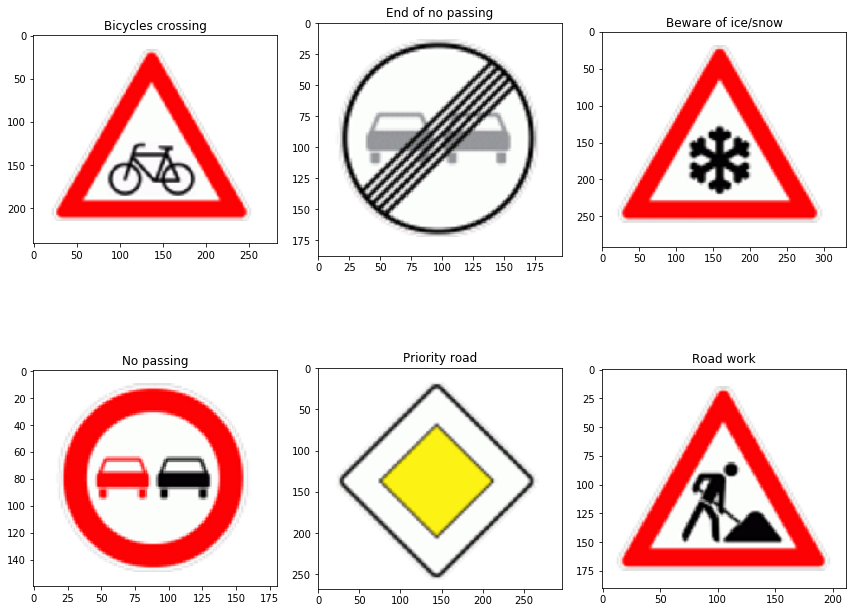

In [19]:
import glob
from PIL import Image
from numpy import newaxis

filelist = glob.glob("test/*.png")
filelist.sort()

plt.rcParams['figure.figsize'] = (12,10)

predict_list = []
softmax_list = []
fig = plt.figure()
idx = 1
print("Traffic Sign Classification")

with tf.Session() as sess:
    saver.restore(sess, "./LeNet/")
    # Load new images and lables
    for file in filelist:
        # Load image
        img = Image.open(file)
        # Display image
        fig_sub = fig.add_subplot(2,3, idx)
        idx += 1
        fig_sub.imshow(img)
        # Resize image
        img = img.resize((32,32))
        # Convert image to ndarray
        img = np.array(img, dtype='float32')
        # Normalize image
        img = (img - 128) / 128
        # Add new dimension to ndarray
        img = img[newaxis, :, :, :]
        # Run prediction
        predict_value = sess.run(tf.argmax(logits,1), feed_dict={x:img})
        softmax_value = sess.run(tf.nn.softmax(logits), feed_dict={x:img})
        predict_list.append(predict_value)
        softmax_list.append(softmax_value)
        # Print sign name
        fig_sub.set_title(sign_names[int(predict_value+1)])

plt.tight_layout()

### Analyze Performance on test images

In [20]:
# Label numbers for the test images
y_newimages = [29, 41, 30, 9, 12, 25]

num_images = len(y_newimages)
correct_predict = 0

for i in range(len(predict_list)):
    if(y_newimages[i] == predict_list[i]):
        correct_predict+=1
        
print("Prediction accuracy of test images = ", (float(correct_predict)/num_images)*100, "%")

Prediction accuracy of test images =  100.0 %


### Top 5 softmax probabilities for test images from internet

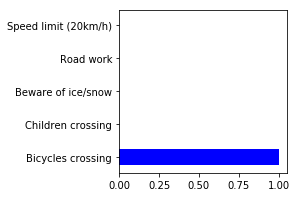

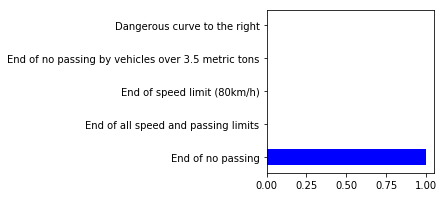

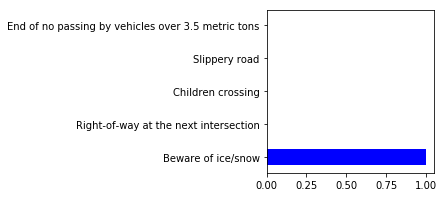

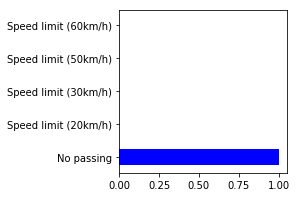

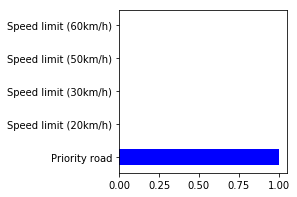

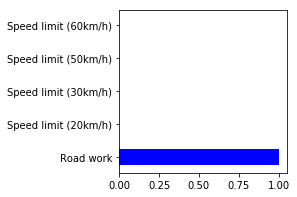

In [21]:
plt.rcParams['figure.figsize'] = (3,3)

width = 0.5

with tf.Session() as sess:
    for softmax in softmax_list:
        values_list, indices_list = sess.run(tf.nn.top_k(tf.constant(softmax), k=5))
        values = values_list[0]
        indices = indices_list[0]
        names = [sign_names[id+1] for id in indices]
        names = [" "] + names
        idx = np.arange(len(indices))
        fig, ax = plt.subplots()
        ax.barh(idx, values, width, align='center', color='blue')
        ax.set_yticklabels(names, minor=False)
                
        